<a href="https://colab.research.google.com/github/CodingPenguins/ML3/blob/main/ML3Week4Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP - Disaster Tweet Classification

## Introduction

This weeks Kaggle competition is about Disaster Tweets, extracting from Twitter. It contains a tweet's text (and hashtags), as well as a classification on whether this was deemed a disaster tweet or not. Additional information (keyword and location) are also provided.
The task is to generate a model predicting the correct binary classification (distaster/non-disaster) using RNNs.

In [251]:
import matplotlib.pyplot as plt
import numpy as np
#import keras
from keras.losses import BinaryCrossentropy
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, GRU, LSTM, Dense, Flatten
from keras.callbacks import ModelCheckpoint
from keras.metrics import Accuracy, Precision, Recall, AUC, MeanSquaredError, SpecificityAtSensitivity
import math
import pandas as pd
import shutil #For moving files in Google Drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
import keras

In [2]:
import os

os.environ['KAGGLE_USERNAME'] = "codingpenguins" # username from the json file
os.environ['KAGGLE_KEY'] = "f3fb1744db746bed654a7c928b0122f3" # key from the json file
!kaggle competitions download -c nlp-getting-started
!unzip -n "/content/nlp-getting-started.zip"

100% 593k/593k [00:00<00:00, 756kB/s]
100% 593k/593k [00:00<00:00, 756kB/s]
Archive:  /content/nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [3]:
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")

## EDA

How does our tweet data look like - or rather, how has it been preprocesseed in the provided csv file?

In [4]:
(df_train).head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_train.shape

(7613, 5)

So, we see that we have 7613 entries in total, provided with a leading id, the text corpus and the target binary classification of 1 (disaster tweet) or 0 (not disaster tweet). We also have a keyword and location provided, although we can immediately see that these are not registered for every tweet. But let us focus on the distribution of both labels within the data first:

In [6]:
print("The dataset contains ", len(df_train[df_train["target"]==1]), " tweets flagged as a disaster tweet and ", len(df_train[df_train["target"]==0]), " tweets flagged as not a distaster tweet.")

The dataset contains  3271  tweets flagged as a disaster tweet and  4342  tweets flagged as not a distaster tweet.


(array([4342.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3271.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

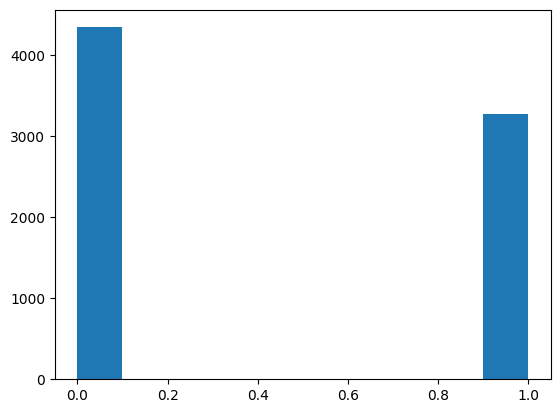

In [7]:
plt.hist(df_train["target"])

In [8]:
print("This leads to an asymmetry ratio of: ", len(df_train[df_train["target"]==1])/len(df_train[df_train["target"]==0]))

This leads to an asymmetry ratio of:  0.7533394748963611


So, as we can see, we have a bias towards non-disaster tweets. If we naively use these without taking measures to compensate for class imbalance or monitoring metrics that indicate e. g. the occurrence of type 2 errors, we might fall into the trap of accidentally classifiying disaster tweets more often as non-disaster as the other way around. We might monitor recall and precision for this purpose in addition to accuracy.

Now how about the other categories in the dataframe? What else do we have here instead of Nan values?

In [9]:
df_train["keyword"].unique()


array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

So, these keywords provided with the tweet might be helpful - if we have enough of them in the data not to overtrain on missing or nan values (or we could justify dropping the tweets not having a category). Let's see:

In [10]:
df_train["keyword"].isnull().values.sum()

61

Well, that is less than 1% of our training data. We should definitely retain the keyword information, e. g. by dropping the 61 keyword less tweets. How about the location a tweet was sent from - is this helpful? We could anticipate that this might help the classification (e. g. regions prone to forest fires or earthquakes have a higher chance of being a disaster tweet using the same language as regions less frequently affected by such catastrophes).

In [11]:
df_train["location"].unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

In [12]:
df_train["location"].isnull().values.sum()

2533

In [13]:
print("Tweets without a location make up a total of ", 100*df_train["location"].isnull().values.sum()/len(df_train["location"]), "% our total training tweets")

Tweets without a location make up a total of  33.27203467752528 % our total training tweets


Well, that  is a lot - dropping tweets contain NaN values is out of the question. We could still try to train on the nan values as well. But how many unique values do we have?

In [14]:
len(df_train["location"].unique())

3342

Well, it appears as if locations are rather unique or seldomly used multiple times. As such, we should rather drop it from our dataframe.

In [15]:
df_train2 = df_train.drop(["location"], axis=1)

Now to drop the 61 keyword less tweets:

In [16]:
df_train3 = df_train2.drop(df_train2[df_train2["keyword"].isnull()].index)

In [17]:
(df_train3)

,id,keyword,text,target
31,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,Crying out for more! Set me ablaze,0
35,53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...
7578,10830,wrecked,@jt_ruff23 @cameronhacker and I wrecked you both,0
7579,10831,wrecked,Three days off from work and they've pretty mu...,0
7580,10832,wrecked,#FX #forex #trading Cramer: Iger's 3 words tha...,0
7581,10833,wrecked,@engineshed Great atmosphere at the British Li...,0


In [18]:
df_train["target"][df_train["keyword"].isnull()].mean()

0.6885245901639344

While we do drop more disaster tweets than non-disaster tweets, considering that we only dropped less than 1% of the data, the asymmetry ratio will only worsen slightly.

How about the distribution of keywords in the dataset?

(array([749., 747., 776., 763., 772., 757., 725., 726., 730., 807.]),
 array([  0.,  22.,  44.,  66.,  88., 110., 132., 154., 176., 198., 220.]),
 <BarContainer object of 10 artists>)

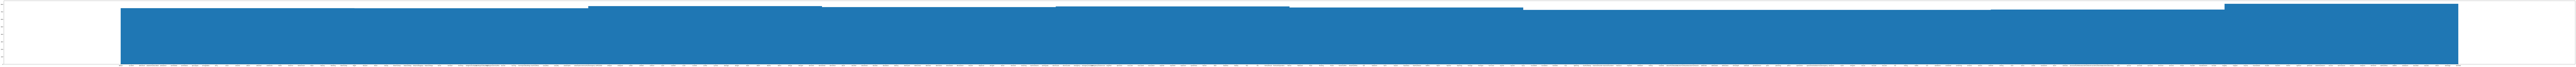

In [19]:
plt.figure(figsize=(400,10))
plt.hist(df_train3["keyword"])

You might want to zoom into the image, but we can clearly see an evenly spread distribution of hte keywords - which is good to work with! We could now also consider dropping the index value and re-indexing the dataframe

In [20]:
df_train3 = df_train3.reset_index()

In [21]:
df_train3.head()

,index,id,keyword,text,target
0,31,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
1,32,49,ablaze,We always try to bring the heavy. #metal #RT h...,0
2,33,50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
3,34,52,ablaze,Crying out for more! Set me ablaze,0
4,35,53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [22]:
df_train4 = df_train3.drop(["index", "id"], axis=1)

In [23]:
df_train4.head()

,keyword,text,target
0,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
1,ablaze,We always try to bring the heavy. #metal #RT h...,0
2,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
3,ablaze,Crying out for more! Set me ablaze,0
4,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


## NLP - Extracting our features from the text corpus

So, since the lecture does not cover NLP and the task explicitly states that external sources should be used, the Kaggle "NLP Getting Started Tutorial" linked with the project has been taken as a starting point. It is accessible here: https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial

### From text corpus to vectors

A first step to be taken is to convert the text field containing a long string into vectorized words. We use the following libraries as taught in the tutorial:

In [24]:
from sklearn import feature_extraction

We initialize a countvectorizer and train it on our training data.

In [25]:
count_vectorizer = feature_extraction.text.CountVectorizer()

Deviating slightly from the tutorial, we do not want a sparse matrix representation in order to ensure compatibility with our model later, so we additionally convert to an array.

In [26]:
train_vec = count_vectorizer.fit_transform(df_train4["text"]).toarray()

In [27]:
print((train_vec).shape) #print(train_vec[0].todense().shape)

(7552, 21592)


So, we have 21592 words entries, which have been counted by said vectorizer. We should also process our test data with it:

In [28]:
test_vec = count_vectorizer.fit_transform(df_test["text"]).toarray()

And now we have a sparse matrix of vectors representing word occurrences: Each "1" signifies a presence of the word, wherein a "0" signifies the absence of said word. Of course, we could take a look at further techniques for transforming our text corpus - thereby pruning the dictionary of words first to increase term relevance (e. g. removing stop words), or further employ techniques reflecting word order or even sentiment. However, the scope of this project is to train and optimize RNNs, so this basic vectorized form has to suffice.

In [113]:
count_vectorizer.get_feature_names_out()

array(['00', '000', '000sijjl3t', ..., 'ûókill', 'ûówe', 'ûówere'],
      dtype=object)

We do see that there is a lot of noise in the data, counted as individual words. With a bit of pre-processing, e. g. focussing on a reduced dictionary of the most important 5000 words, we could probably achieve better results. And, of course, using this unprocessed matrix makes the model almost impossible to train in reasonable time before time-out of this Colab.

So let's try another approach, this time using Keras Text Preprocessing capabilities - and train it on the unprocessed Text Corpus and pad it afterwards, choosing a maximum length of 2000. This approach is based partially on https://pub.towardsai.net/keras-for-multi-label-text-classification-86d194311d0e (Section "Size of Vocabulary" and "Padding and making all input sequences of the same length and preparing input sequences"); however, we do not follow any of their preprocessing techniques.

In [134]:
Token = keras.preprocessing.text.Tokenizer()

The above statement initializes a tokenizer, which will extract each word from a given sample.

In [135]:
Token.fit_on_texts(df_train4["text"])

We now generate a one-hot-encoding (see also documentation here: https://www.tensorflow.org/text/guide/word_embeddings) for each word found in the text corpus.

In [136]:
Trained = Token.texts_to_sequences(df_train4["text"])

Now, for a given text, which is still the same, unrefined text as before, we return numbers corresponding to the extracted feature groups for each word in the sequence.

In [137]:
Train_padded = keras.utils.pad_sequences(Trained, maxlen=1000, padding='post')

And the last step pads the data, so that non-occurrences still show with a zero - this allows us to have vectors of the same length for each input.

In [138]:
print(Train_padded)

[[ 6920  2910  1922 ...     0     0     0]
 [   50   280   894 ...     0     0     0]
 [ 6923   435    58 ...     0     0     0]
 ...
 [22649  6790  6789 ...     0     0     0]
 [22651   207  5588 ...     0     0     0]
 [ 2149  2441    80 ...     0     0     0]]


In [139]:
print(Train_padded.shape)

(7552, 1000)


So we have now an occurrence matrix, reduced in length to the 2000 most important features. While we did not bother addressing the noise within the text corpus itself, it should have reduced some of it - and reduced the size accordingly. We will process the testing corpus accordingly:

In [140]:
Token_test = keras.preprocessing.text.Tokenizer()
Token_test.fit_on_texts(df_test["text"])
Tested = Token_test.texts_to_sequences(df_test["text"])
Test_padded = keras.utils.pad_sequences(Tested, maxlen=1000, padding='post')

## Model building: A first basic RNN

Now, we want to build our first RNN - with basic assumptions, so we can iteratively improve on it e. g. by re-evaluating our choices and hyperparameter tuning.

## A first model

For this, we start with an empty Sequential model in Keras, and add our layers. The first layer should be accepting our size of our dictionary (that is, the count of each unique word in the text corpus, which was 1000 after preprocessing), and output a reduced size. Since usually numbers of base 2 are chosen, 64 is arbitrarily selected. Then, our first RNN layer is selected - 16 to keep the parameters reasonable. We choose a relu activation function as its default. Afterwards, a fully connected NN layer with 16 nodes is built. And since we are classifying binarily, we need a final layer with node 1 able to classify, hence employing the sigmoid activation function.

In [142]:
model1 = Sequential()
model1.add(Embedding(input_dim=1000, output_dim=64))
model1.add(SimpleRNN((16)))
model1.add(Dense(16, activation = "relu"))
model1.add(Dense(1, activation='sigmoid'))
model1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 64)          64000     
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 16)                1296      
                                                                 
 dense_16 (Dense)            (None, 16)                272       
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 65585 (256.19 KB)
Trainable params: 65585 (256.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We choose a binary crossentropy loss function (after all, we are dealing with a binary classification problem) and Keras standard stochastic gradient descrent optimizer.  As discussed, we observe accuracy, recall and specificity and additionally MSE as metrics.

We should split off our validation data from the training data - we will try to work with 10% of the dataset as validation data.

In [143]:
X_train, X_val, y_train, y_val = train_test_split(Train_padded, df_train4["target"].to_numpy(), test_size = .1)

In [144]:
model1.compile(
    loss=BinaryCrossentropy(from_logits=False),
    optimizer="sgd",
    metrics=["accuracy","MeanSquaredError", "Recall", "Precision"] #,, ,"recall" "MSE" ,
)


In [145]:
callbacks = [
    ModelCheckpoint("save_at_{epoch}.keras"),
]

We still have to choose a batch size - the more we take, the longer the training and the better the convergence/reliability. We will go with 64 for the time being

In [146]:
batch_size = 64

In [147]:
modelfit1 = model1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=5,
    callbacks = callbacks
)


Epoch 1/5
107/107 [==============================] - 71s 651ms/step - loss: 0.6854 - accuracy: 0.5722 - mean_squared_error: 0.2461 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6830 - val_accuracy: 0.5741 - val_mean_squared_error: 0.2450 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/5
107/107 [==============================] - 66s 617ms/step - loss: 0.6830 - accuracy: 0.5722 - mean_squared_error: 0.2449 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6821 - val_accuracy: 0.5741 - val_mean_squared_error: 0.2445 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/5
107/107 [==============================] - 64s 602ms/step - loss: 0.6828 - accuracy: 0.5722 - mean_squared_error: 0.2448 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6822 - val_accuracy: 0.5741 - val_mean_squared_error: 0.2446 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/5
107/107 [==============================] - 63s 589ms/step - loss: 0.6828 - acc

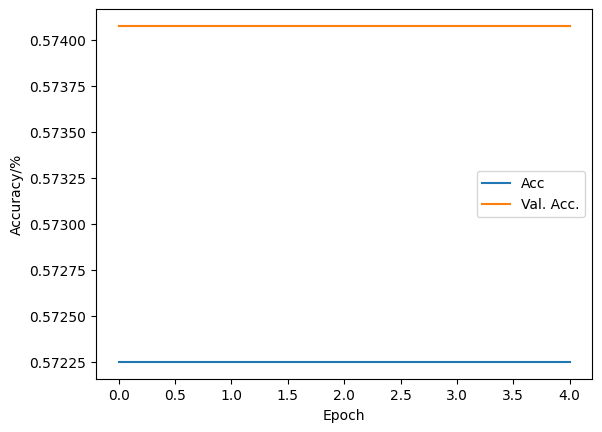

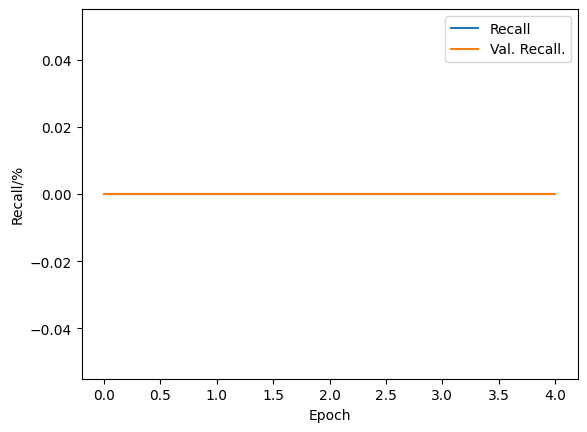

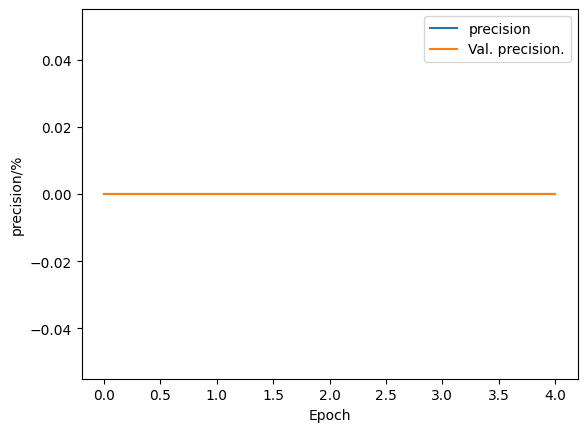

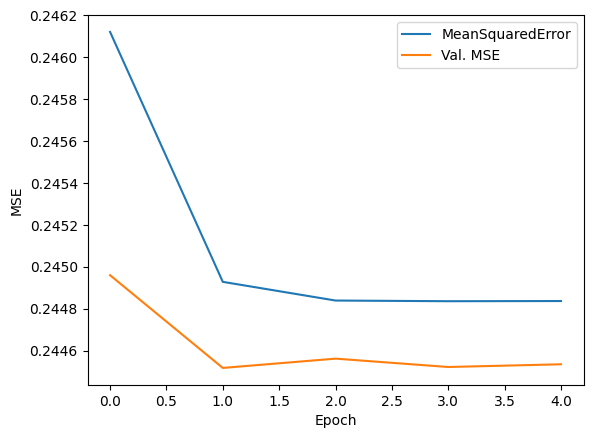

In [149]:
plt.plot(modelfit1.history["accuracy"], label = "Acc")
plt.plot(modelfit1.history["val_accuracy"], label = "Val. Acc.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy/%")
plt.show()
plt.plot(modelfit1.history["recall"], label = "Recall")
plt.plot(modelfit1.history["val_recall"], label = "Val. Recall.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Recall/%")
plt.show()
plt.plot(modelfit1.history["precision"], label = "precision")
plt.plot(modelfit1.history["val_precision"], label = "Val. precision.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("precision/%")
plt.show()
plt.plot(modelfit1.history["mean_squared_error"], label = "MeanSquaredError")
plt.plot(modelfit1.history["val_mean_squared_error"], label = "Val. MSE")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

Even after 5 epochs, we see a stable accuracy result of 57%. This is better than average guessing, but a rather disappointing model. Let's review or model.

## Second model: Increasing the output of the embedding layer

Should we increase the output dimension of the embedding layer to match our RNN? Let's see if that turns out differently.

In [150]:
model2 = Sequential()
model2.add(Embedding(input_dim=1000, output_dim=64))
model2.add(SimpleRNN((64)))
model2.add(Dense(16, activation = "relu"))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 64)          64000     
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_18 (Dense)            (None, 16)                1040      
                                                                 
 dense_19 (Dense)            (None, 1)                 17        
                                                                 
Total params: 73313 (286.38 KB)
Trainable params: 73313 (286.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [151]:
model2.compile(
    loss=BinaryCrossentropy(from_logits=False),
    optimizer="sgd",
    metrics=["accuracy","MeanSquaredError", "Recall", "Precision"] #,, ,"recall" "MSE" ,
)


In [152]:
modelfit2 = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=5,
    callbacks = callbacks
)


Epoch 1/5
107/107 [==============================] - 69s 627ms/step - loss: 0.6838 - accuracy: 0.5722 - mean_squared_error: 0.2453 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6824 - val_accuracy: 0.5741 - val_mean_squared_error: 0.2446 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/5
107/107 [==============================] - 66s 620ms/step - loss: 0.6830 - accuracy: 0.5722 - mean_squared_error: 0.2449 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6821 - val_accuracy: 0.5741 - val_mean_squared_error: 0.2445 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/5
107/107 [==============================] - 66s 612ms/step - loss: 0.6830 - accuracy: 0.5722 - mean_squared_error: 0.2449 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6822 - val_accuracy: 0.5741 - val_mean_squared_error: 0.2446 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/5
107/107 [==============================] - 66s 614ms/step - loss: 0.6830 - acc

This had no measurable impact on our model (at least in terms of accuracy).

## Third model

Is our NN the bottle-neck - should we allow more fully connected nodes? We increase the number accordingly and try again:

In [153]:
model3 = Sequential()
model3.add(Embedding(input_dim=1000, output_dim=64))
model3.add(SimpleRNN((64)))
model3.add(Dense(64, activation = "relu"))
model3.add(Dense(1, activation='sigmoid'))
model3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 64)          64000     
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 64)                4160      
                                                                 
 dense_21 (Dense)            (None, 1)                 65        
                                                                 
Total params: 76481 (298.75 KB)
Trainable params: 76481 (298.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [154]:
model3.compile(
    loss=BinaryCrossentropy(from_logits=False),
    optimizer="sgd",
    metrics=["accuracy","MeanSquaredError", "Recall", "Precision"] #,, ,"recall" "MSE" ,
)


In [155]:
modelfit3 = model3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=3,
    callbacks = callbacks
)


Epoch 1/3
107/107 [==============================] - 68s 620ms/step - loss: 0.6827 - accuracy: 0.5696 - mean_squared_error: 0.2448 - recall: 0.0299 - precision: 0.4531 - val_loss: 0.6825 - val_accuracy: 0.5741 - val_mean_squared_error: 0.2447 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/3
107/107 [==============================] - 63s 588ms/step - loss: 0.6829 - accuracy: 0.5722 - mean_squared_error: 0.2449 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6823 - val_accuracy: 0.5741 - val_mean_squared_error: 0.2446 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/3
107/107 [==============================] - 63s 589ms/step - loss: 0.6829 - accuracy: 0.5722 - mean_squared_error: 0.2449 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6822 - val_accuracy: 0.5741 - val_mean_squared_error: 0.2445 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00


So, at least for now, we do not achieve any reasonable increase in accuracy with more nodes in the densily connected layer.

## Fourth model: Revert back to 16 densily connected nodes, increase output of embedding layer

So, assuming that our information cannot be embedded in 64 layers from a starting corpus of 1000, maybe we should increase the embedding output? Let's increase the embedding layers output as well as the number of nodes in the RNN

In [156]:
model4 = Sequential()
model4.add(Embedding(input_dim=1000, output_dim=128))
model4.add(SimpleRNN((128)))
model4.add(Dense(16, activation = "relu"))
model4.add(Dense(1, activation='sigmoid'))
model4.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 128)         128000    
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 128)               32896     
                                                                 
 dense_22 (Dense)            (None, 16)                2064      
                                                                 
 dense_23 (Dense)            (None, 1)                 17        
                                                                 
Total params: 162977 (636.63 KB)
Trainable params: 162977 (636.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [157]:
model4.compile(
    loss=BinaryCrossentropy(from_logits=False),
    optimizer="sgd",
    metrics=["accuracy","MeanSquaredError", "Recall", "Precision"] #,, ,"recall" "MSE" ,
)


In [158]:
modelfit4 = model4.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=3,
    callbacks = callbacks
)


Epoch 1/3
107/107 [==============================] - 72s 663ms/step - loss: 0.6839 - accuracy: 0.5722 - mean_squared_error: 0.2454 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6822 - val_accuracy: 0.5741 - val_mean_squared_error: 0.2445 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/3
107/107 [==============================] - 69s 642ms/step - loss: 0.6829 - accuracy: 0.5722 - mean_squared_error: 0.2449 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6834 - val_accuracy: 0.5741 - val_mean_squared_error: 0.2451 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/3
107/107 [==============================] - 68s 639ms/step - loss: 0.6833 - accuracy: 0.5722 - mean_squared_error: 0.2451 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6861 - val_accuracy: 0.5741 - val_mean_squared_error: 0.2464 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00


Again, we see no improvement.

## Fifth and sixth model: Replacing simple RNN with LSTM or GRU

Maybe we should try another RNN - like LSTM or GRU?

In [171]:
model5 = Sequential()
model5.add(Embedding(input_dim=1000, output_dim=128))
model5.add(GRU((128)))
model5.add(Dense(16, activation = "relu"))
model5.add(Dense(1, activation='sigmoid'))
model5.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, None, 128)         128000    
                                                                 
 gru (GRU)                   (None, 128)               99072     
                                                                 
 dense_30 (Dense)            (None, 16)                2064      
                                                                 
 dense_31 (Dense)            (None, 1)                 17        
                                                                 
Total params: 229153 (895.13 KB)
Trainable params: 229153 (895.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [172]:
model5.compile(
    loss=BinaryCrossentropy(from_logits=False),
    optimizer="sgd",
    metrics=["accuracy","MeanSquaredError", "Recall", "Precision"] #,, ,"recall" "MSE" ,
)


In [173]:
modelfit5 = model5.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=5,
    callbacks = callbacks
)


Epoch 1/5
107/107 [==============================] - 8s 61ms/step - loss: 0.6873 - accuracy: 0.5722 - mean_squared_error: 0.2471 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6844 - val_accuracy: 0.5741 - val_mean_squared_error: 0.2456 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/5
107/107 [==============================] - 5s 42ms/step - loss: 0.6838 - accuracy: 0.5722 - mean_squared_error: 0.2453 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6828 - val_accuracy: 0.5741 - val_mean_squared_error: 0.2449 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/5
107/107 [==============================] - 4s 38ms/step - loss: 0.6830 - accuracy: 0.5722 - mean_squared_error: 0.2450 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6823 - val_accuracy: 0.5741 - val_mean_squared_error: 0.2446 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/5
107/107 [==============================] - 4s 38ms/step - loss: 0.6828 - accuracy: 0

In [174]:
model6 = Sequential()
model6.add(Embedding(input_dim=1000, output_dim=128))
model6.add(LSTM((128)))
model6.add(Dense(16, activation = "relu"))
model6.add(Dense(1, activation='sigmoid'))
model6.summary()
model6.compile(
    loss=BinaryCrossentropy(from_logits=False),
    optimizer="sgd",
    metrics=["accuracy","MeanSquaredError", "Recall", "Precision"] #,, ,"recall" "MSE" ,
)
modelfit6 = model6.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=5,
    callbacks = callbacks
)


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, None, 128)         128000    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_32 (Dense)            (None, 16)                2064      
                                                                 
 dense_33 (Dense)            (None, 1)                 17        
                                                                 
Total params: 261665 (1022.13 KB)
Trainable params: 261665 (1022.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
107/107 [==============================] - 9s 60ms/step - loss: 0.6872 - accuracy: 0.5661 - mean_squared_error: 0.2470 - recall: 0.04

GRU and LSTM are way more performant compared to simpleRNN, but cannot reach higher accuracy.

## Eight model: Adding another RNN layer

We could try to add another LSTM layer receiving the input from the previous:

In [186]:
model7 = Sequential()
model7.add(Embedding(input_dim=1000, output_dim=128))
model7.add(LSTM(128, return_sequences=True))
model7.add(LSTM(256))
model7.add(Dense(16, activation = "relu"))
model7.add(Dense(1, activation='sigmoid'))
model7.summary()

model7.compile(
    loss=BinaryCrossentropy(from_logits=False),
    optimizer="sgd",
    metrics=["accuracy","MeanSquaredError", "Recall", "Precision"] #,, ,"recall" "MSE" ,
)

modelfit7 = model7.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=5,
    callbacks = callbacks
)


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, None, 128)         128000    
                                                                 
 lstm_16 (LSTM)              (None, None, 128)         131584    
                                                                 
 lstm_17 (LSTM)              (None, 256)               394240    
                                                                 
 dense_34 (Dense)            (None, 16)                4112      
                                                                 
 dense_35 (Dense)            (None, 1)                 17        
                                                                 
Total params: 657953 (2.51 MB)
Trainable params: 657953 (2.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
107/107

And still, we cannot achieve more than 57% accuracy. At this point, it appears that we are limited by the proprocessing performed.

## Going back to preprocessing: Modifying the virtual dictionary:

So, assuming we are increasing or decreasing our token size, does this yield different results? We try a maximum length of 2000 and 200, respectively.

In [199]:
#test
Token2 = keras.preprocessing.text.Tokenizer()
Token2.fit_on_texts(df_train4["text"])
Trained2 = Token2.texts_to_sequences(df_train4["text"])
Train_padded2 = keras.utils.pad_sequences(Trained2, maxlen=2000, padding='post')
Token_test2 = keras.preprocessing.text.Tokenizer()
Token_test2.fit_on_texts(df_test["text"])
Tested2 = Token_test2.texts_to_sequences(df_test["text"])
Test_padded2 = keras.utils.pad_sequences(Tested2, maxlen=2000, padding='post')

In [200]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(Train_padded2, df_train4["target"].to_numpy(), test_size = .1)

In [202]:
model8 = Sequential()
model8.add(Embedding(input_dim=2000, output_dim=128))
model8.add(LSTM(128, return_sequences=True))
model8.add(LSTM(256))
model8.add(Dense(16, activation = "relu"))
model8.add(Dense(1, activation='sigmoid'))
model8.summary()

model8.compile(
    loss=BinaryCrossentropy(from_logits=False),
    optimizer="sgd",
    metrics=["accuracy","MeanSquaredError", "Recall", "Precision"] #,, ,"recall" "MSE" ,
)

modelfit8 = model8.fit(
    X_train2, y_train2,
    validation_data=(X_val2, y_val2),
    batch_size=batch_size,
    epochs=3,
    callbacks = callbacks
)


Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, None, 128)         256000    
                                                                 
 lstm_32 (LSTM)              (None, None, 128)         131584    
                                                                 
 lstm_33 (LSTM)              (None, 256)               394240    
                                                                 
 dense_50 (Dense)            (None, 16)                4112      
                                                                 
 dense_51 (Dense)            (None, 1)                 17        
                                                                 
Total params: 785953 (3.00 MB)
Trainable params: 785953 (3.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/3
107/107

In [262]:
#test
Token2 = keras.preprocessing.text.Tokenizer()
Token2.fit_on_texts(df_train4["text"])
Trained2 = Token2.texts_to_sequences(df_train4["text"])
Train_padded2 = keras.utils.pad_sequences(Trained2, maxlen=200, padding='post')
Token_test2 = keras.preprocessing.text.Tokenizer()
Token_test2.fit_on_texts(df_test["text"])
Tested2 = Token_test2.texts_to_sequences(df_test["text"])
Test_padded2 = keras.utils.pad_sequences(Tested2, maxlen=200, padding='post')

In [263]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(Train_padded2, df_train4["target"].to_numpy(), test_size = .1)

In [264]:
model8 = Sequential()
model8.add(Embedding(input_dim=200, output_dim=128))
model8.add(LSTM(128, return_sequences=True))
model8.add(LSTM(256))
model8.add(Dense(16, activation = "relu"))
model8.add(Dense(1, activation='sigmoid'))
model8.summary()

model8.compile(
    loss=BinaryCrossentropy(from_logits=False),
    optimizer="sgd",
    metrics=["accuracy","MeanSquaredError", "Recall", "Precision"] #,, ,"recall" "MSE" ,
)

modelfit8 = model8.fit(
    X_train2, y_train2,
    validation_data=(X_val2, y_val2),
    batch_size=batch_size,
    epochs=5,
    callbacks = callbacks
)


Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_48 (Embedding)    (None, None, 128)         25600     
                                                                 
 lstm_52 (LSTM)              (None, None, 128)         131584    
                                                                 
 lstm_53 (LSTM)              (None, 256)               394240    
                                                                 
 dense_101 (Dense)           (None, 16)                4112      
                                                                 
 dense_102 (Dense)           (None, 1)                 17        
                                                                 
Total params: 555553 (2.12 MB)
Trainable params: 555553 (2.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
107/107

Again, we do not see any improvement in our accuracy, at all. At this stage, we have to assume that proper pre-processing of our input text corpus is necessary - more so than optimizing the models chosen.

## A quick check - would another, non-RNN model perform better on the data?

In [ ]:
#model9.add(Embedding(input_dim=1000, output_dim=128))
#model9.add(LSTM(128, return_sequences=True))
#model9.add(LSTM(256))

In [233]:
X_train.shape

(6796, 1000)

In [246]:
model9 = Sequential()
model9.add(Flatten(input_shape = (1000,)))
model9.add(Dense(64, activation = "relu"))
model9.add(Dense(64, activation = "relu"))
model9.add(Dense(1, activation='sigmoid'))
model9.summary()

model9.compile(
    loss=BinaryCrossentropy(from_logits=False),
    optimizer="sgd",
    metrics=["accuracy","MeanSquaredError", "Recall", "Precision"] #,, ,"recall" "MSE" ,
)

modelfit9 = model9.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=5,
    callbacks = callbacks
)


Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 1000)              0         
                                                                 
 dense_96 (Dense)            (None, 64)                64064     
                                                                 
 dense_97 (Dense)            (None, 64)                4160      
                                                                 
 dense_98 (Dense)            (None, 1)                 65        
                                                                 
Total params: 68289 (266.75 KB)
Trainable params: 68289 (266.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
107/107 [==============================] - 1s 6ms/step - loss: 1629718925898595446911139840.0000 - accuracy: 0.5636 - mean_squared_error:

Using a basic Neural Network, we again achieve the same accuracy.

## New Section

Let's predict our test data labels:

In [248]:
predictions = model7.predict(Test_padded2)

102/102 [==============================] - 1s 7ms/step


We have no reason to modify our prediction threshold, which should be set at 0.5.

In [249]:
predictions[predictions >= 0.5 ] = 1
predictions[predictions < 0.5] = 0

In [255]:
sample = pd.read_csv("/content/sample_submission.csv")

In [257]:
sample["target"] = predictions

In [258]:
sample.to_csv("Kaggle_submission.csv", encoding='utf-8', index=False)

When submitting this to Kaggle, we receive a public score of approx 57%. This means we are consistent with our training and validation accuracy.

# Discussion

## The good parts

After minimally invasive pre-processing of our text corpus provided using a first technique producing sparse matrixes (not a good idea for input to RNNs) and use of a tokenizer to predict the occurrences using the full text corpus itself, with subsequent padding to have corresponding lengths for each sample, several models were created and improved (or rather, attempts were made to improve these). Each model achieved approx 57% accuracy, no matter which modification was performed, hinting at the unprocessed nature of the text corpus being the limiting factor. Consistent results accross training, validation and testing data were achieved, underlining this issue. In particular, the same result in the testing data highlights that no issue in the naive text corpus processing is present.

## The bad parts

To be honest: My models are not fit for purpose - we are only slightly better of with either model than with tossing a coin! However, there is only so much to do without delving further into the pre-processing aspects, which goes more in the direction of NLP than RNNs! Considering that most models participating in the challenge do achieve an accuracy below 80%, it is reasonable to state that the pre-processing is not trivial.

## Possible improvements

The most important thing to do is delving into the topic of NLP (which was not the purpose of this weeks project!) and see how we can improve on the pre-processing and feature generation based on the text corpus. Only with such a text corpus, it is reasonable to re-attempt the model generation and optimization.

# References

[1] https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial

[2] https://pub.towardsai.net/keras-for-multi-label-text-classification-86d194311d0e

[3] https://www.tensorflow.org/text/guide/word_embeddings